In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
print(torch.__version__)

1.4.0


## Fashion MINST dataset


In [0]:
from torchvision.datasets import FashionMNIST

In [3]:
# Getting the train and test parts of the dataset
data_train = FashionMNIST("FashionMNIST/",
                          download=True,
                          train=True)

data_test = FashionMNIST("FashionMNIST/",
                          download=True,
                          train=False)

# In fact, it's already stored as torch tensor, but we'll need
# to work with the numpy representation, so let's do the convertion:
X_train = data_train.train_data.numpy()
y_train = data_train.train_labels.numpy()

X_test = data_test.test_data.numpy()
y_test = data_test.test_labels.numpy()



Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


The datasets consists of images belonging to one out of 10 classes:

| Label | Description | | Label | Description |
| ---       
| 0        | T-shirt/top   || 5        | Sandal         |
| 1        | Trouser        || 6        | Shirt             |
| 2        | Pullover       || 7        | Sneaker       |
| 3        | Dress           || 8        | Bag              |
| 4        | Coat             || 9        | Ankle boot  |






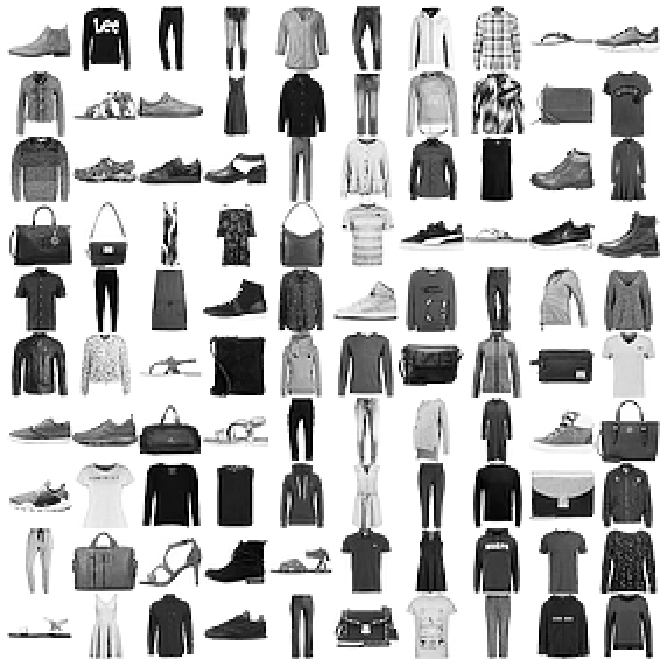

In [4]:
plt.figure(figsize=(12,12))
plt.imshow(X_test[:100].reshape(10, 10, 28, 28)
           .transpose(0, 2, 1, 3).reshape(280, 280), cmap='Greys')
plt.axis('off');

### Input preprocessing

So far our data is held as numpy arrays of unsigned byte type, i.e. it lies within a range from 0 to 255. Also, the shape of our input is 3-dimensional (num_images, height, width), while our `model` takes 2-dimensional "arrays of 1-dimensional images" (num_images, height * width).

We have to convert that to `torch` tensors and reshape the input. Also, it's a good idea to normalize your image data to lie within a $[0, 1]$ interval. Let's write a function that does all these things:

In [0]:
# Write a function to convert X and y to torch tensors while
# rescaling X to fit into [0, 1] interval and reshaping it properly

# Hint: make sure your input tensor dtype is same as the
# parameters of the model (should be torch.float)

def preprocess_data(X, y):
  X_preprocessed = torch.reshape(torch.from_numpy(X/ 255.).type(torch.float32), (-1, 784))
  y_preprocessed = torch.from_numpy(y)
  return X_preprocessed, y_preprocessed

The simplest way to check this function is to use it to calculate loss:

In [0]:
# Defining the loss function:
loss_function = torch.nn.CrossEntropyLoss()

# Defining the model
input_size = 28 * 28 # number of pixels per image
output_size = 10 # number of classes
model = torch.nn.Linear(in_features=input_size,
                        out_features=output_size)

In [7]:
processed_X, processed_y = preprocess_data(X_train[:100], y_train[:100])

assert processed_X.min().item() >= 0 and \
       processed_X.max().item() <= 1, "Make sure your input is >= 0 and <= 1"

class_scores = model(processed_X)
print("Loss is:", loss_function(class_scores, processed_y).item())

Loss is: 2.3395960330963135


### Some utilities

In [0]:
# Batch generator
# (here's a very brief description of what python generators are:
# https://stackoverflow.com/a/231855/3801744)
def get_batches(X, y, batch_size, shuffle=False):
  if shuffle:
    shuffle_ids = np.random.permutation(len(X))
    X = X[shuffle_ids].copy()
    y = y[shuffle_ids].copy()
  for i_picture in range(0, len(X), batch_size):
    # Get batch and preprocess it:
    batch_X = X[i_picture:i_picture + batch_size]
    batch_y = y[i_picture:i_picture + batch_size]
    
    # 'return' the batch (see the link above to
    # better understand what 'yield' does)
    yield preprocess_data(batch_X, batch_y)

We'll add one more utility to keep track of loss values and plot them at each epoch:

In [0]:
from IPython.display import clear_output

class Logger:
  def __init__(self):
    self.train_loss_batch = []
    self.train_loss_epoch = []
    self.test_loss_batch = []
    self.test_loss_epoch = []
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    self.epoch_counter = 0

  def fill_train(self, loss):
    self.train_loss_batch.append(loss)
    self.train_batches_per_epoch += 1

  def fill_test(self, loss):
    self.test_loss_batch.append(loss)
    self.test_batches_per_epoch += 1

  def finish_epoch(self):
    self.train_loss_epoch.append(np.mean(
        self.train_loss_batch[-self.train_batches_per_epoch:]
    ))
    self.test_loss_epoch.append(np.mean(
        self.test_loss_batch[-self.test_batches_per_epoch:]
    ))
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    
    clear_output()
  
    print("epoch #{} \t train_loss: {:.8} \t test_loss: {:.8}".format(
              self.epoch_counter,
              self.train_loss_epoch[-1],
              self.test_loss_epoch [-1]
          ))
    
    self.epoch_counter += 1

    plt.figure(figsize=(11, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.train_loss_batch, label='train loss')
    plt.xlabel('# batch iteration')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(self.train_loss_epoch, label='average train loss')
    plt.plot(self.test_loss_epoch , label='average test loss' )
    plt.legend()
    plt.xlabel('# epoch')
    plt.ylabel('loss')
    plt.show();

### Putting it all together

Here's the setting up part, copy-pasted from previous cells:

In [0]:
# Defining the loss function:
loss_function = torch.nn.CrossEntropyLoss()

# Defining the model
input_size = 28 * 28 # number of pixels per image
output_size = 10 # number of classes
#model = torch.nn.Linear(in_features=input_size,
#                        out_features=output_size)

model = torch.nn.Sequential(
  torch.nn.Linear(input_size, 150),
  torch.nn.ELU(),
  torch.nn.Linear(150, output_size),
)

# Setting up the optimizer
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Now it's your turn to code the learning process:

epoch #29 	 train_loss: 0.16958604 	 test_loss: 0.47654706


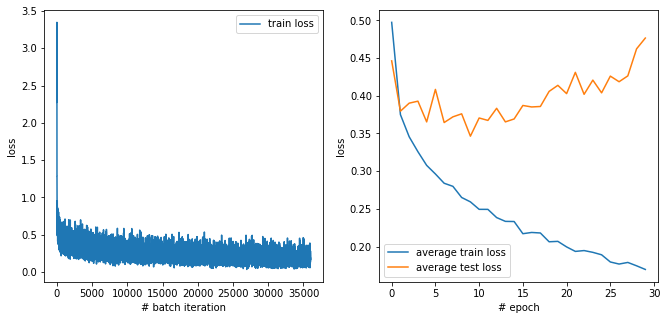

In [16]:
n_epochs = 30
batch_size=100

logger = Logger()

for i_epoch in range(n_epochs):
  for batch_X, batch_y in get_batches(X_train, y_train,
                                      batch_size=batch_size,
                                      shuffle=True):

    # Compute the loss, zero the gradients, and make an optimization step
    predictions = model(batch_X) # compute the predictions
    loss = loss_function(predictions, batch_y) # compute the loss
    logger.fill_train(loss.item())

    model.zero_grad() # zero the gradients
    loss.backward() # compute new gradients
    optimizer.step() # do an optimization step

    logger.fill_train(loss.item())

  for batch_X, batch_y in get_batches(X_test, y_test,
                                      batch_size=batch_size):

    # Compute the loss
    predictions = model(batch_X) # compute the predictions
    loss = loss_function(predictions, batch_y) # compute the loss

    logger.fill_test(loss.item())

  logger.finish_epoch()

Now that we've trained our model, let's evaluate the accuracy of the predictions. Here's a function we can use to compute the predictions on the test set:

In [0]:
def get_test_predictions(model, batch_size=100):
  predictions_test = np.concatenate([
    model(batch_X).to('cpu').detach().numpy()
    for batch_X, batch_y in get_batches(X_test, y_test, batch_size)
  ], axis=0)
  return np.argmax(predictions_test, axis=1)

from sklearn.metrics import accuracy_score

Use it to calculate the accuracy score here. How much did you get?

In [18]:
# Compute and print out the test accuracy of your model
accuracy_score(get_test_predictions(model), y_test)

0.8724

## Convolutional layers

<img src='https://cdn-images-1.medium.com/max/1600/0*iqNdZWyNeCr5tCkc.' alt='CNN animation'>

A common CNN architecture is to interleave convolutional and downsampling layers while increasing the number of filters:

<img src='https://cdn-images-1.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg' alt='img'>
(image taken from https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

Convolutional layers in torch expect their input to be of 4-dimensional shape: $(B, C, H, W)$. Here $B$ is the number images per batch, $C$ is the number of channels (e.g. 1 for a greyscale image, 3 for an RGB one, or number of filters from the previous convolutional layer). $H$ and $W$ are height and width in pixels.

This means, at the beggining of our network we need to reshape our images from $(B, 784)$ to $(B, 1, 28, 28)$. In the end we'll want to reshape it back to 2 dimensions in order to apply a linear connection.

For some reason torch doesn't have a reshaping layer, so we'll implement our own:

In [0]:
class Reshape(torch.nn.Module):
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.reshape(*self.shape)
  

In [0]:
# normalise and send to CUDA

def preprocess_data(X, y):
  X_preprocessed = torch.tensor(X / 255.,
                                dtype=torch.float).reshape(-1, 28 * 28)
  y_preprocessed = torch.tensor(y)
  return X_preprocessed.cuda(), y_preprocessed.cuda()

In [0]:
from torch import nn
device = torch.device('cuda')

### Insert missing pieces

model = nn.Sequential(
  Reshape(-1, 1, 28, 28),
  nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3),
  nn.Dropout(p = 0.2),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(in_features=676, out_features=100),
  nn.ReLU(),
  nn.Linear(in_features=100, out_features=10)
).to(device)

epoch #19 	 train_loss: 0.16208552 	 test_loss: 0.35995651


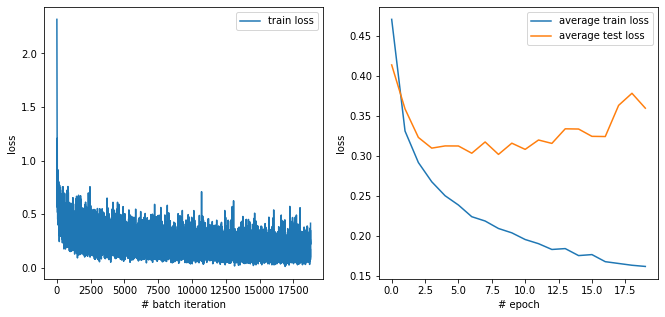

In [27]:
# Define the hyperparameters of our model:
learning_rate = 0.005
batch_size = 64
dropout_rate = 0.2


# Creating the instances of the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

logger = Logger()

# Let's train for 20 epochs
for i_epoch in range(20):
  model.train() # setting the model to training mode
  for batch_X, batch_y in get_batches(X_train, y_train,
                                      batch_size=batch_size, shuffle=True):
    # print (batch_X.shape)
    predictions = model(batch_X) # compute the predictions
    # print (predictions.shape)
    loss = loss_function(predictions, batch_y) # compute the loss
    logger.fill_train(loss.item())

    model.zero_grad() # zero the gradients
    loss.backward() # compute new gradients
    optimizer.step() # do an optimization step

  # Now, let's evaluate on the test part:
  model.eval() # setting the model to evaluatioin mode
  for batch_X, batch_y in get_batches(X_test, y_test,
                                      batch_size=batch_size):
    loss = loss_function(model(batch_X), batch_y)
    logger.fill_test(loss.item())
  
  logger.finish_epoch()

In [28]:
n_parameters = 0
for parameter in model.parameters():
  n_parameters += parameter.reshape(-1).shape[0]

print(n_parameters)

68750


In [29]:
print(accuracy_score(y_test, get_test_predictions(model)))

0.8974


### Having a look at misclassified items

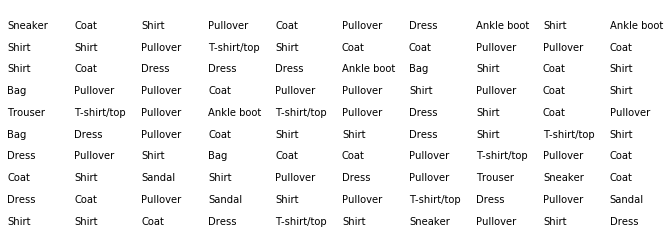

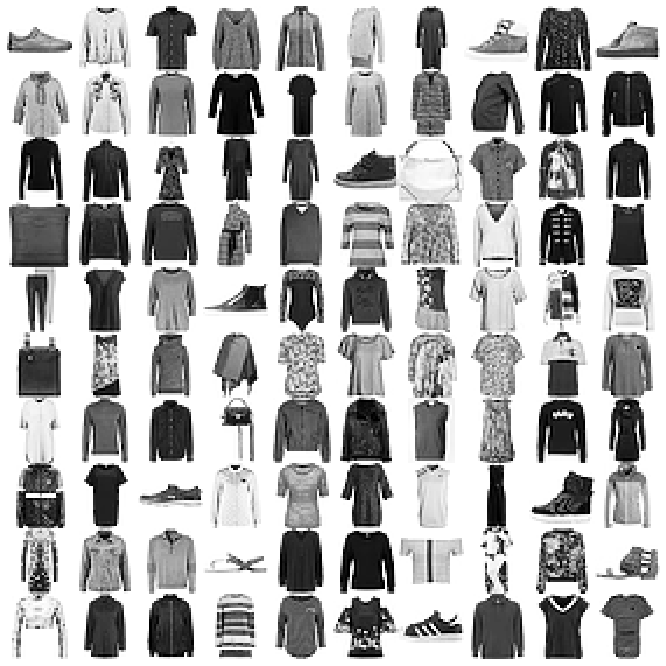

In [30]:
predictions_test = get_test_predictions(model)

wrongly_predicted = X_test[predictions_test != y_test]
wrongly_predicted_labels = y_test[predictions_test != y_test]

label_names = np.array([
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
])


# Print and plot the first 100:
wrongly_predicted_labels = \
  label_names[wrongly_predicted_labels[:100]].reshape(10, 10)

for ix in range(10):
  for iy in range(10):
    plt.text(ix / 5, iy / 10, (wrongly_predicted_labels[-1 - iy, ix]))
plt.axis('off')
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(wrongly_predicted[:100].reshape(10, 10, 28, 28)
           .transpose(0, 2, 1, 3).reshape(280, 280), cmap='Greys')
plt.axis('off');

### Exercise 1. Adding more convolutional magic

```
model = torch.nn.Sequential(
            Reshape(-1, 1, 28, 28),
            torch.nn.Conv2d(in_channels=1,
                            out_channels=8,
                            kernel_size=3,
                            padding=1),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(in_channels=8,
                            out_channels=16,
                            kernel_size=3,
                            padding=1),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=3,
                            padding=1),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(2, padding=1),
            Reshape(-1, 512),
            torch.nn.Linear(512, 10)
        ).to(device)
```


### Exercise 2. Add batch norm magic
Add batch norm (with default params) between convolution and ReLU
 - ```nn.BatchNorm*d``` (1d for dense, 2d for conv)
 - usually better to put them after linear/conv but before nonlinearity

Re-train the network with the same optimizer, it should get at least 20% validation accuracy at peak.

To know more about batch_norm and data covariate shift

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

### Exercise 3. Examine Filters
Evaluate trained filters of your convolutional layer using https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

### Exercise 4. Repeat the classification task from Day4 (NotMNIST)
with Convolutional magic.